In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")  
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(f"Running on TPU: {tpu.master()}")
except Exception as e:
    print(f"Could not initialize TPU: {e}")
    strategy = tf.distribute.get_strategy()  # Fallback to default CPU/GPU
    print("Running on CPU or single GPU")

# Print number of available TPU cores
print("Number of devices:", strategy.num_replicas_in_sync, "🚀")

E0000 00:00:1753388615.263297      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753388635.481417      10 service.cc:148] XLA service 0x576771fb79b0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753388635.481467      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753388635.481471      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753388635.481474      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753388635.481477      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753388635.481479      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753388635.481482      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753388635.481484      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753388635.481487      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

File path

In [3]:
GCS_PATH = '/kaggle/input/gan-getting-started'
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Function that make images to tensor in [-1,1], and parses TFRecord data.



In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Load the dataset

In [5]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(1)

Visualize examples

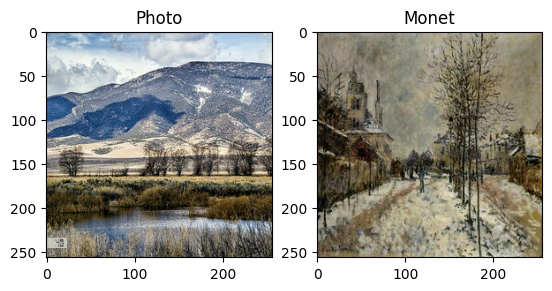

In [46]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Downsample function, use group normalization with groups=-1 as instance normalization.

In [47]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

Upsample function

In [48]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))


    result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

The U-net generator with down sample, up sample and skip connections

In [49]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Reflection Padding for ResNet

In [50]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif isinstance(padding, (list, tuple)) and len(padding) == 2:
            self.padding = ((padding[0], padding[0]), (padding[1], padding[1]))
        elif isinstance(padding, (list, tuple)) and len(padding) == 4:
            self.padding = ((padding[0], padding[1]), (padding[2], padding[3]))
        else:
            raise ValueError("`padding` type error")

    def call(self, inputs):
        return tf.pad(
            inputs,
            paddings=[[0, 0],                      # batch
                      [self.padding[0][0], self.padding[0][1]],  # height
                      [self.padding[1][0], self.padding[1][1]],  # width
                      [0, 0]],                     # channels
            mode='REFLECT'
        )

    def get_config(self):
        config = super().get_config()
        config.update({"padding": self.padding})
        return config

The ResNet Block:

In [51]:
def resnet_block(x, filters, kernel_size=3):
    initializer = tf.random_normal_initializer(0., 0.02)
    padding = kernel_size // 2

    y = ReflectionPadding2D(padding=(padding, padding))(x)
    y = layers.Conv2D(filters, kernel_size, strides=1, padding='valid',
                      kernel_initializer=initializer, use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    y = ReflectionPadding2D(padding=(padding, padding))(y)
    y = layers.Conv2D(filters, kernel_size, strides=1, padding='valid',
                      kernel_initializer=initializer, use_bias=False)(y)
    y = layers.BatchNormalization()(y)

    return layers.add([x, y])

The ResNet Generator:

In [52]:
def ResNetGenerator():
    input_shape = (256, 256, 3)
    num_res_blocks = 9
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=input_shape)

    # Initial conv: 7x7 reflection padded
    padded_input = ReflectionPadding2D(padding=(3, 3))(inputs)
    conv1 = layers.Conv2D(64, kernel_size=7, strides=1, padding='valid',
                          kernel_initializer=initializer, use_bias=False)(padded_input)
    norm1 = layers.BatchNormalization()(conv1)
    relu1 = layers.ReLU()(norm1)

    # Downsampling
    down1 = layers.Conv2D(128, kernel_size=3, strides=2, padding='same',
                          kernel_initializer=initializer, use_bias=False)(relu1)
    norm2 = layers.BatchNormalization()(down1)
    relu2 = layers.ReLU()(norm2)

    down2 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same',
                          kernel_initializer=initializer, use_bias=False)(relu2)
    norm3 = layers.BatchNormalization()(down2)
    relu3 = layers.ReLU()(norm3)

    # ResNet blocks
    res_output = relu3
    for _ in range(num_res_blocks):
        res_output = resnet_block(res_output, 256)  # 请确保 resnet_block 也已改为 BatchNorm

    # Upsampling
    up1 = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False)(res_output)
    norm4 = layers.BatchNormalization()(up1)
    relu4 = layers.ReLU()(norm4)

    up2 = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False)(relu4)
    norm5 = layers.BatchNormalization()(up2)
    relu5 = layers.ReLU()(norm5)

    # Output layer
    padded_output = ReflectionPadding2D(padding=(3, 3))(relu5)
    final_conv = layers.Conv2D(3, kernel_size=7, strides=1, padding='valid',
                               kernel_initializer=initializer)(padded_output)
    output_image = layers.Activation('tanh')(final_conv)

    return tf.keras.Model(inputs=inputs, outputs=output_image)

A PatchGAN discriminator that classify if the image is true or fake. is output a smaller 2D image and pixel value evaluate the true or false.

In [53]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inputs = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inputs

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inputs, outputs=last)

Train Cycle

In [54]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def call(self, inputs):
        return inputs
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Loss functions for discriminator and generator

Note that discriminator_loss is just average of real_loss and generated_loss, where real loss is the loss that if the real image been classified to real (tf.ones_like(real)), and vice versa.

For generator_loss, we want to to deceive the discriminator. So we want the loss that if the generated image been classified to real (tf.ones_like(generated))

In [55]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
        
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

Cycle loss and identityloss

cycle loss: to check if after m -> p -> m, m is still like m

identity loss: to check if we use m -> p on a p, p is still like p

In [56]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
        
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Training

In [ ]:
with strategy.scope():

    # monet_generator = Generator() # transforms photos to Monet-esque paintings
    # photo_generator = Generator() # transforms Monet paintings to be more like photos
    monet_generator = ResNetGenerator() # transforms photos to Monet-esque paintings
    photo_generator = ResNetGenerator()

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

    cycle_gan_model.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=50
    )

Epoch 1/50


I0000 00:00:1753393200.850921      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12429412532038404352
I0000 00:00:1753393210.946324     909 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(11194798247655677804), session_name()
I0000 00:00:1753393385.138298     909 tpu_compile_op_common.cc:245] Compilation of 11194798247655677804 with session name  took 2m54.191904779s and succeeded
I0000 00:00:1753393385.401951     909 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(11194798247655677804), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_12429412532038404352", property.function_library_fingerprint = 5355746336755015525, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wr

300/300 ━━━━━━━━━━━━━━━━━━━━ 520s 778ms/step - monet_disc_loss: nan - monet_gen_loss: nan - photo_disc_loss: nan - photo_gen_loss: nan
Epoch 2/50
122/300 ━━━━━━━━━━━━━━━━━━━━ 2:18 777ms/step - monet_disc_loss: nan - monet_gen_loss: nan - photo_disc_loss: nan - photo_gen_loss: nan

In [ ]:
_, ax = plt.subplots(7, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(7)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()